# Case 2: Siemens AI-Driven Sales Forecasting

## Overview
This case study involves building a monthly sales forecasting model using real sales data from Siemens’ Smart Infrastructure Division in Germany. The objective is to apply machine learning techniques to predict future sales based on historical data and macro-economic indicators.

## Business Problem
- Manual sales forecasting is time-consuming and relies on human judgment.  
- Data is scattered across multiple sources, making it difficult to derive insights.  
- Inaccurate forecasts lead to financial losses, such as inefficient inventory management and unsatisfied customers.

## Objective
- Develop an AI-driven predictive model to automate the forecasting process.  
- Evaluate the model using Root Mean Squared Error (RMSE).  
- Submit predictions for May 2022 - February 2023 in a structured CSV format.


---

**This notebook was developed by:**
- João Venichand - 20211644  
- Gonçalo Custódio - 20211643  
- Diogo Correia - 20211586  
- Duarte Emanuel - 20240564


# 1. Import the Libraries

In [349]:
import calendar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, boxcox
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from prophet import Prophet
from sklearn.model_selection import GridSearchCV

#warnings.simplefilter(action='ignore', category=FutureWarning)

# 2. Load Datasets

Import Sales Data

In [350]:
sales_data = pd.read_csv("sales_data.csv")
sales_data.head(5)

,DATE,Mapped_GCK,Sales_EUR
0,01.10.2018,#1,0
1,02.10.2018,#1,0
2,03.10.2018,#1,0
3,04.10.2018,#1,0
4,05.10.2018,#1,0


Import Market Data

In [351]:
market_data = pd.read_excel("market_data.xlsx", header=None)
market_data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,NaN,China,China,France,France,Germany,Germany,Italy,Italy,Japan,...,production index,production index,production index,production index,production index,production index,production index,production index,production index,production index
1,Index 2010=100 (if not otherwise noted),Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,...,France: Machinery and equipment n.e.c.,Germany: Machinery and equipment n.e.c.,United States: Electrical equipment,World: Electrical equipment,Switzerland: Electrical equipment,United Kingdom: Electrical equipment,Italy: Electrical equipment,Japan: Electrical equipment,France: Electrical equipment,Germany: Electrical equipment
2,date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,...,PRO28250_org,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org
3,2004m2,16.940704,16.940704,112.091273,83.458866,82.623037,79.452532,124.289603,86.560493,109.33401,...,118.274109,80.82901,117.723991,NaN,81.1,120.706516,141.510864,106.161262,102.077057,85.9132
4,2004m3,23.711852,23.711852,136.327976,106.168192,100.556582,97.012918,143.411662,106.344544,140.884616,...,148.121841,102.130104,119.220779,NaN,76.690307,138.30955,152.880234,140.288741,117.225685,97.670815


# 3. Sales Dataset Analysis

Check for missing values

In [352]:
missing_values = sales_data["Sales_EUR"].isna().sum()
missing_values

0

Count occurrences of 0 and non-zero Sales

In [353]:
zero_count = (sales_data["Sales_EUR"] == 0).sum()
non_zero_count = (sales_data["Sales_EUR"] != 0).sum()

print(f"Zero Sales Count: {zero_count}")
print(f"Non-Zero Sales Count: {non_zero_count}")

Zero Sales Count: 7135
Non-Zero Sales Count: 2667


Sales Distribution by Product (excluding 0 sales values)

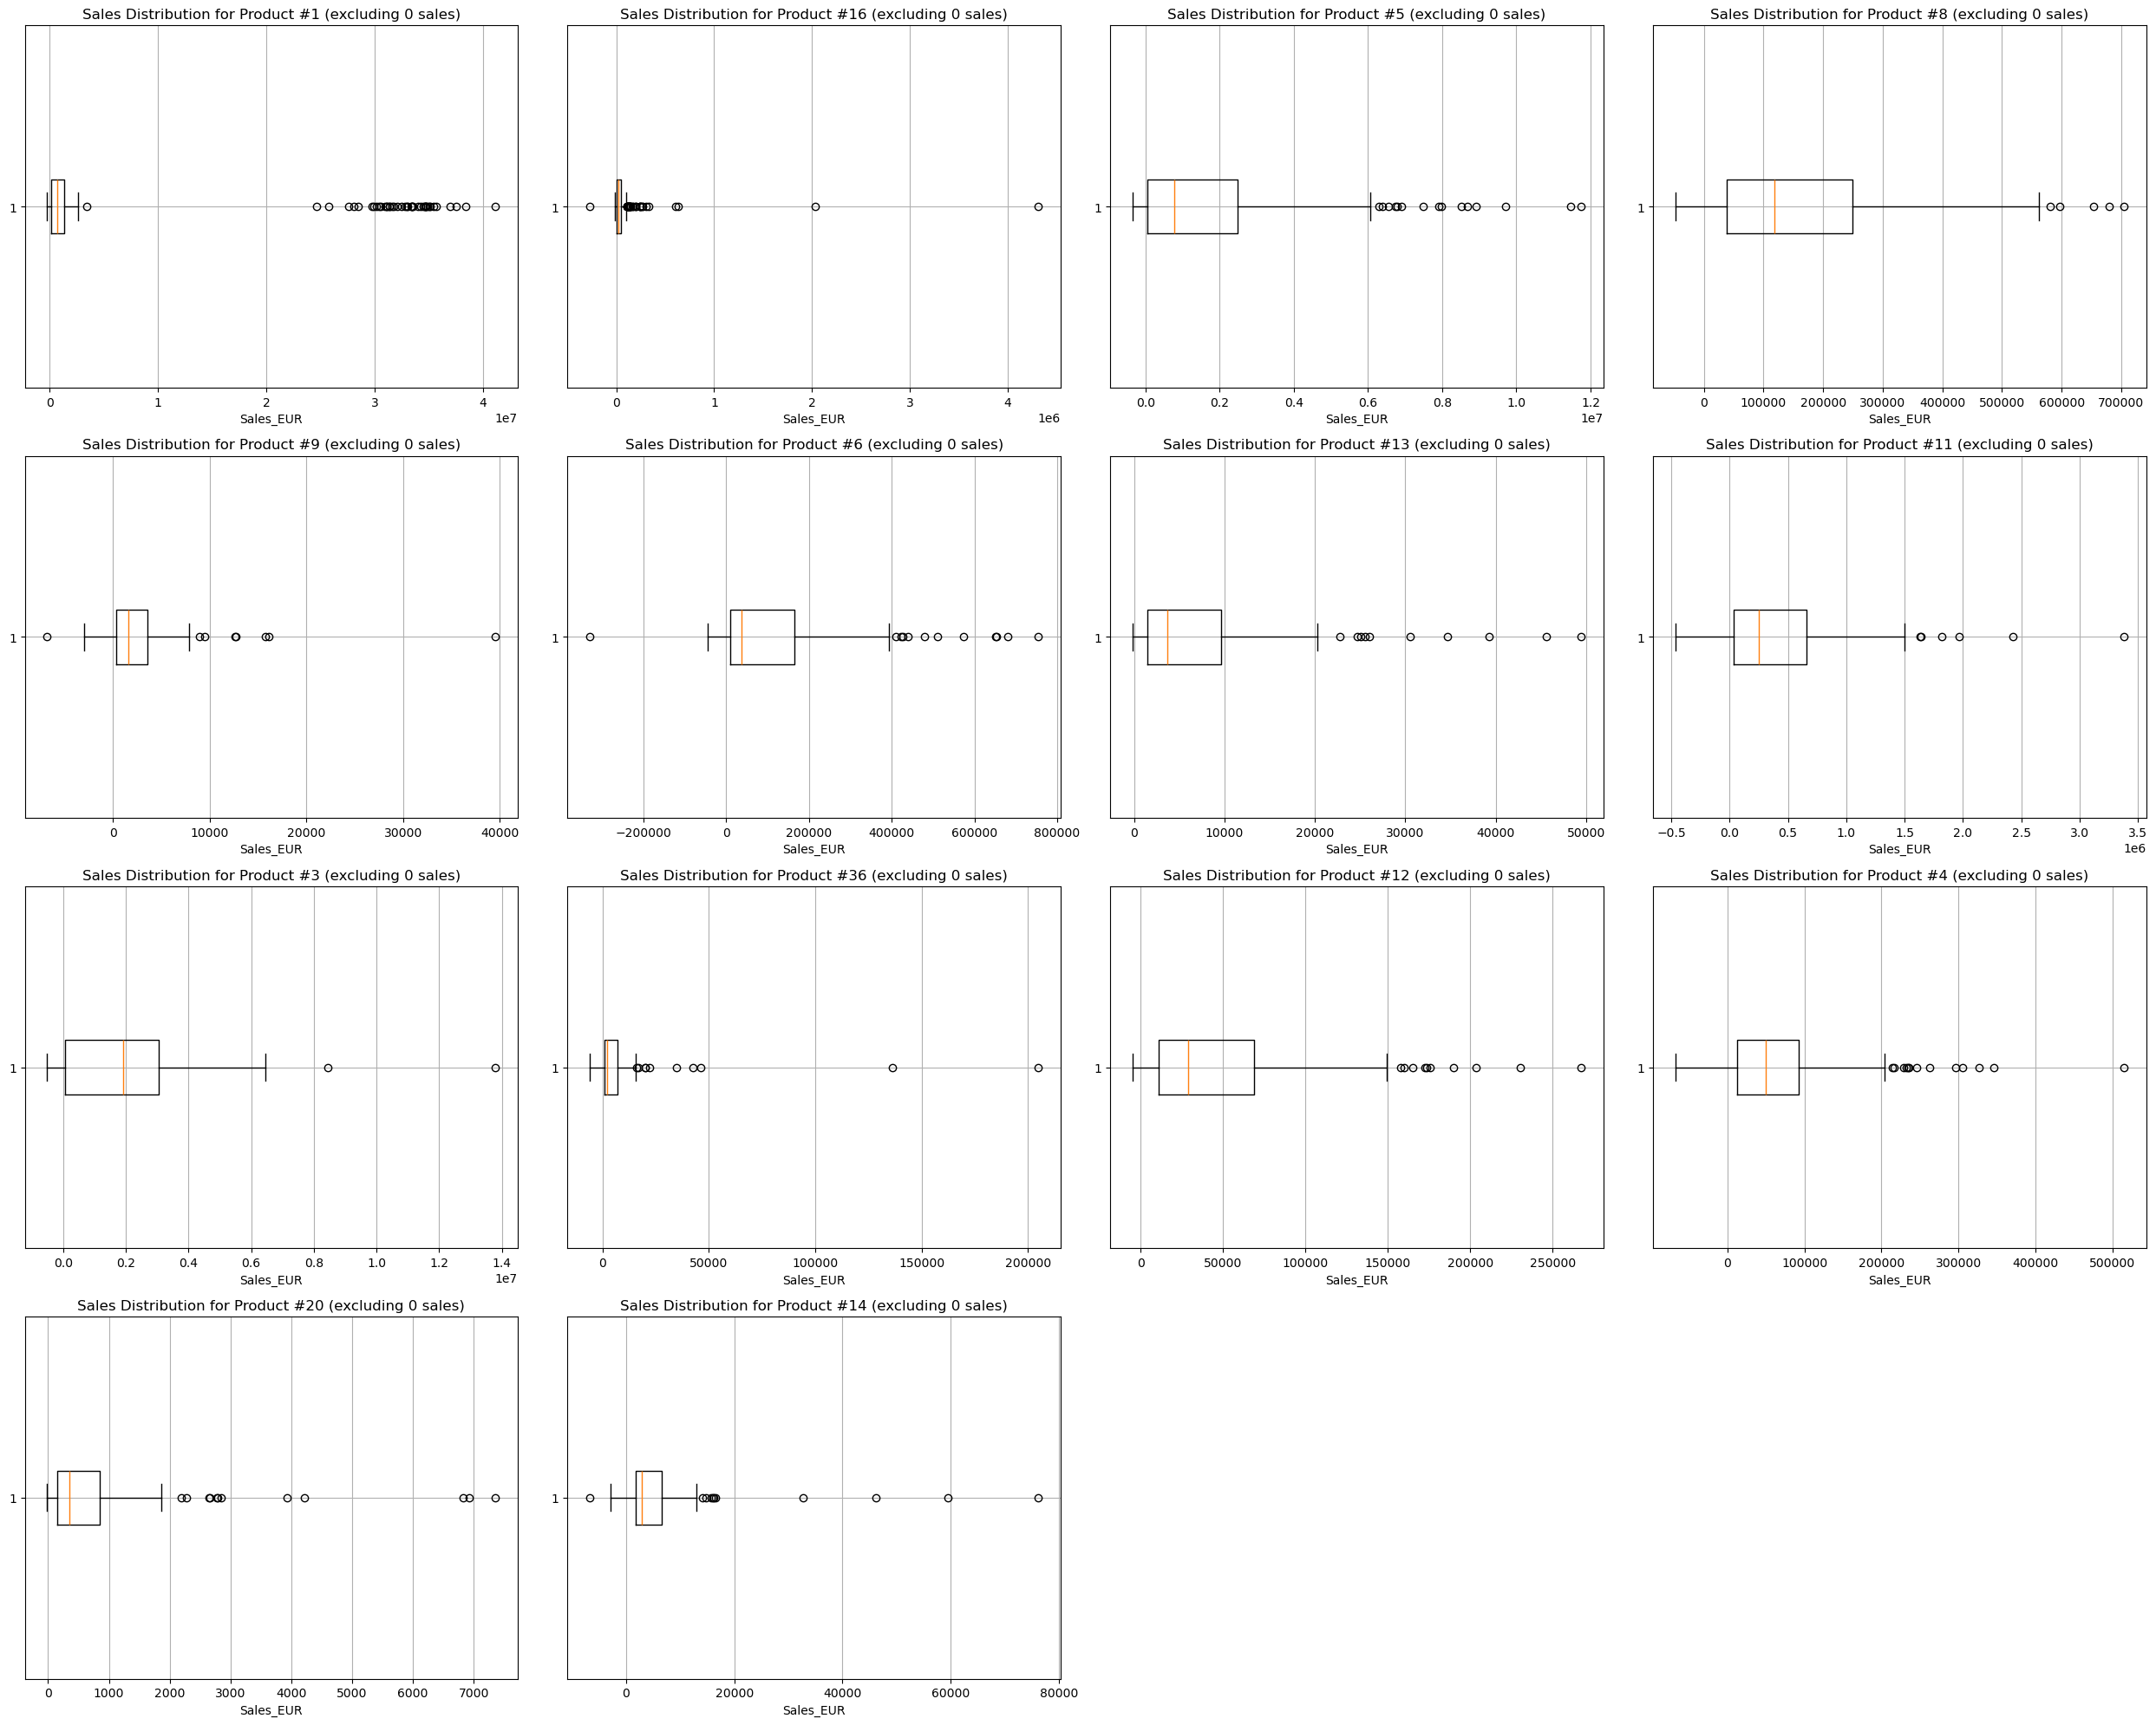

In [354]:
filtered_sales = sales_data[sales_data["Sales_EUR"] != 0]
unique_products = filtered_sales["Mapped_GCK"].unique()
num_columns = 4
num_rows = (len(unique_products) // num_columns) + int(len(unique_products) % num_columns != 0)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 5 * num_rows))
axes = axes.flatten()

for i, product in enumerate(unique_products):
    product_data = filtered_sales[filtered_sales["Mapped_GCK"] == product]["Sales_EUR"]
    axes[i].boxplot(product_data, vert=False)
    axes[i].set_title(f"Sales Distribution for Product {product} (excluding 0 sales)")
    axes[i].set_xlabel("Sales_EUR")
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [355]:
sales_data['DATE'] = pd.to_datetime(sales_data['DATE'], format='%d.%m.%Y')
sales_data['Weekday'] = sales_data['DATE'].dt.day_name()
sales_data['Year'] = sales_data['DATE'].dt.year
sales_data['Month'] = sales_data['DATE'].dt.month
monthly_sales_data = sales_data.groupby(["Mapped_GCK", "Year", "Month"])["Sales_EUR"].sum().reset_index()
print(monthly_sales_data)

    Mapped_GCK  Year  Month  Sales_EUR
0           #1  2018     10   36098918
1           #1  2018     11    5140757
2           #1  2018     12   37889610
3           #1  2019      1   27728146
4           #1  2019      2   34793162
..         ...   ...    ...        ...
597         #9  2021     12      14935
598         #9  2022      1       2065
599         #9  2022      2        902
600         #9  2022      3       4452
601         #9  2022      4       3285

[602 rows x 4 columns]


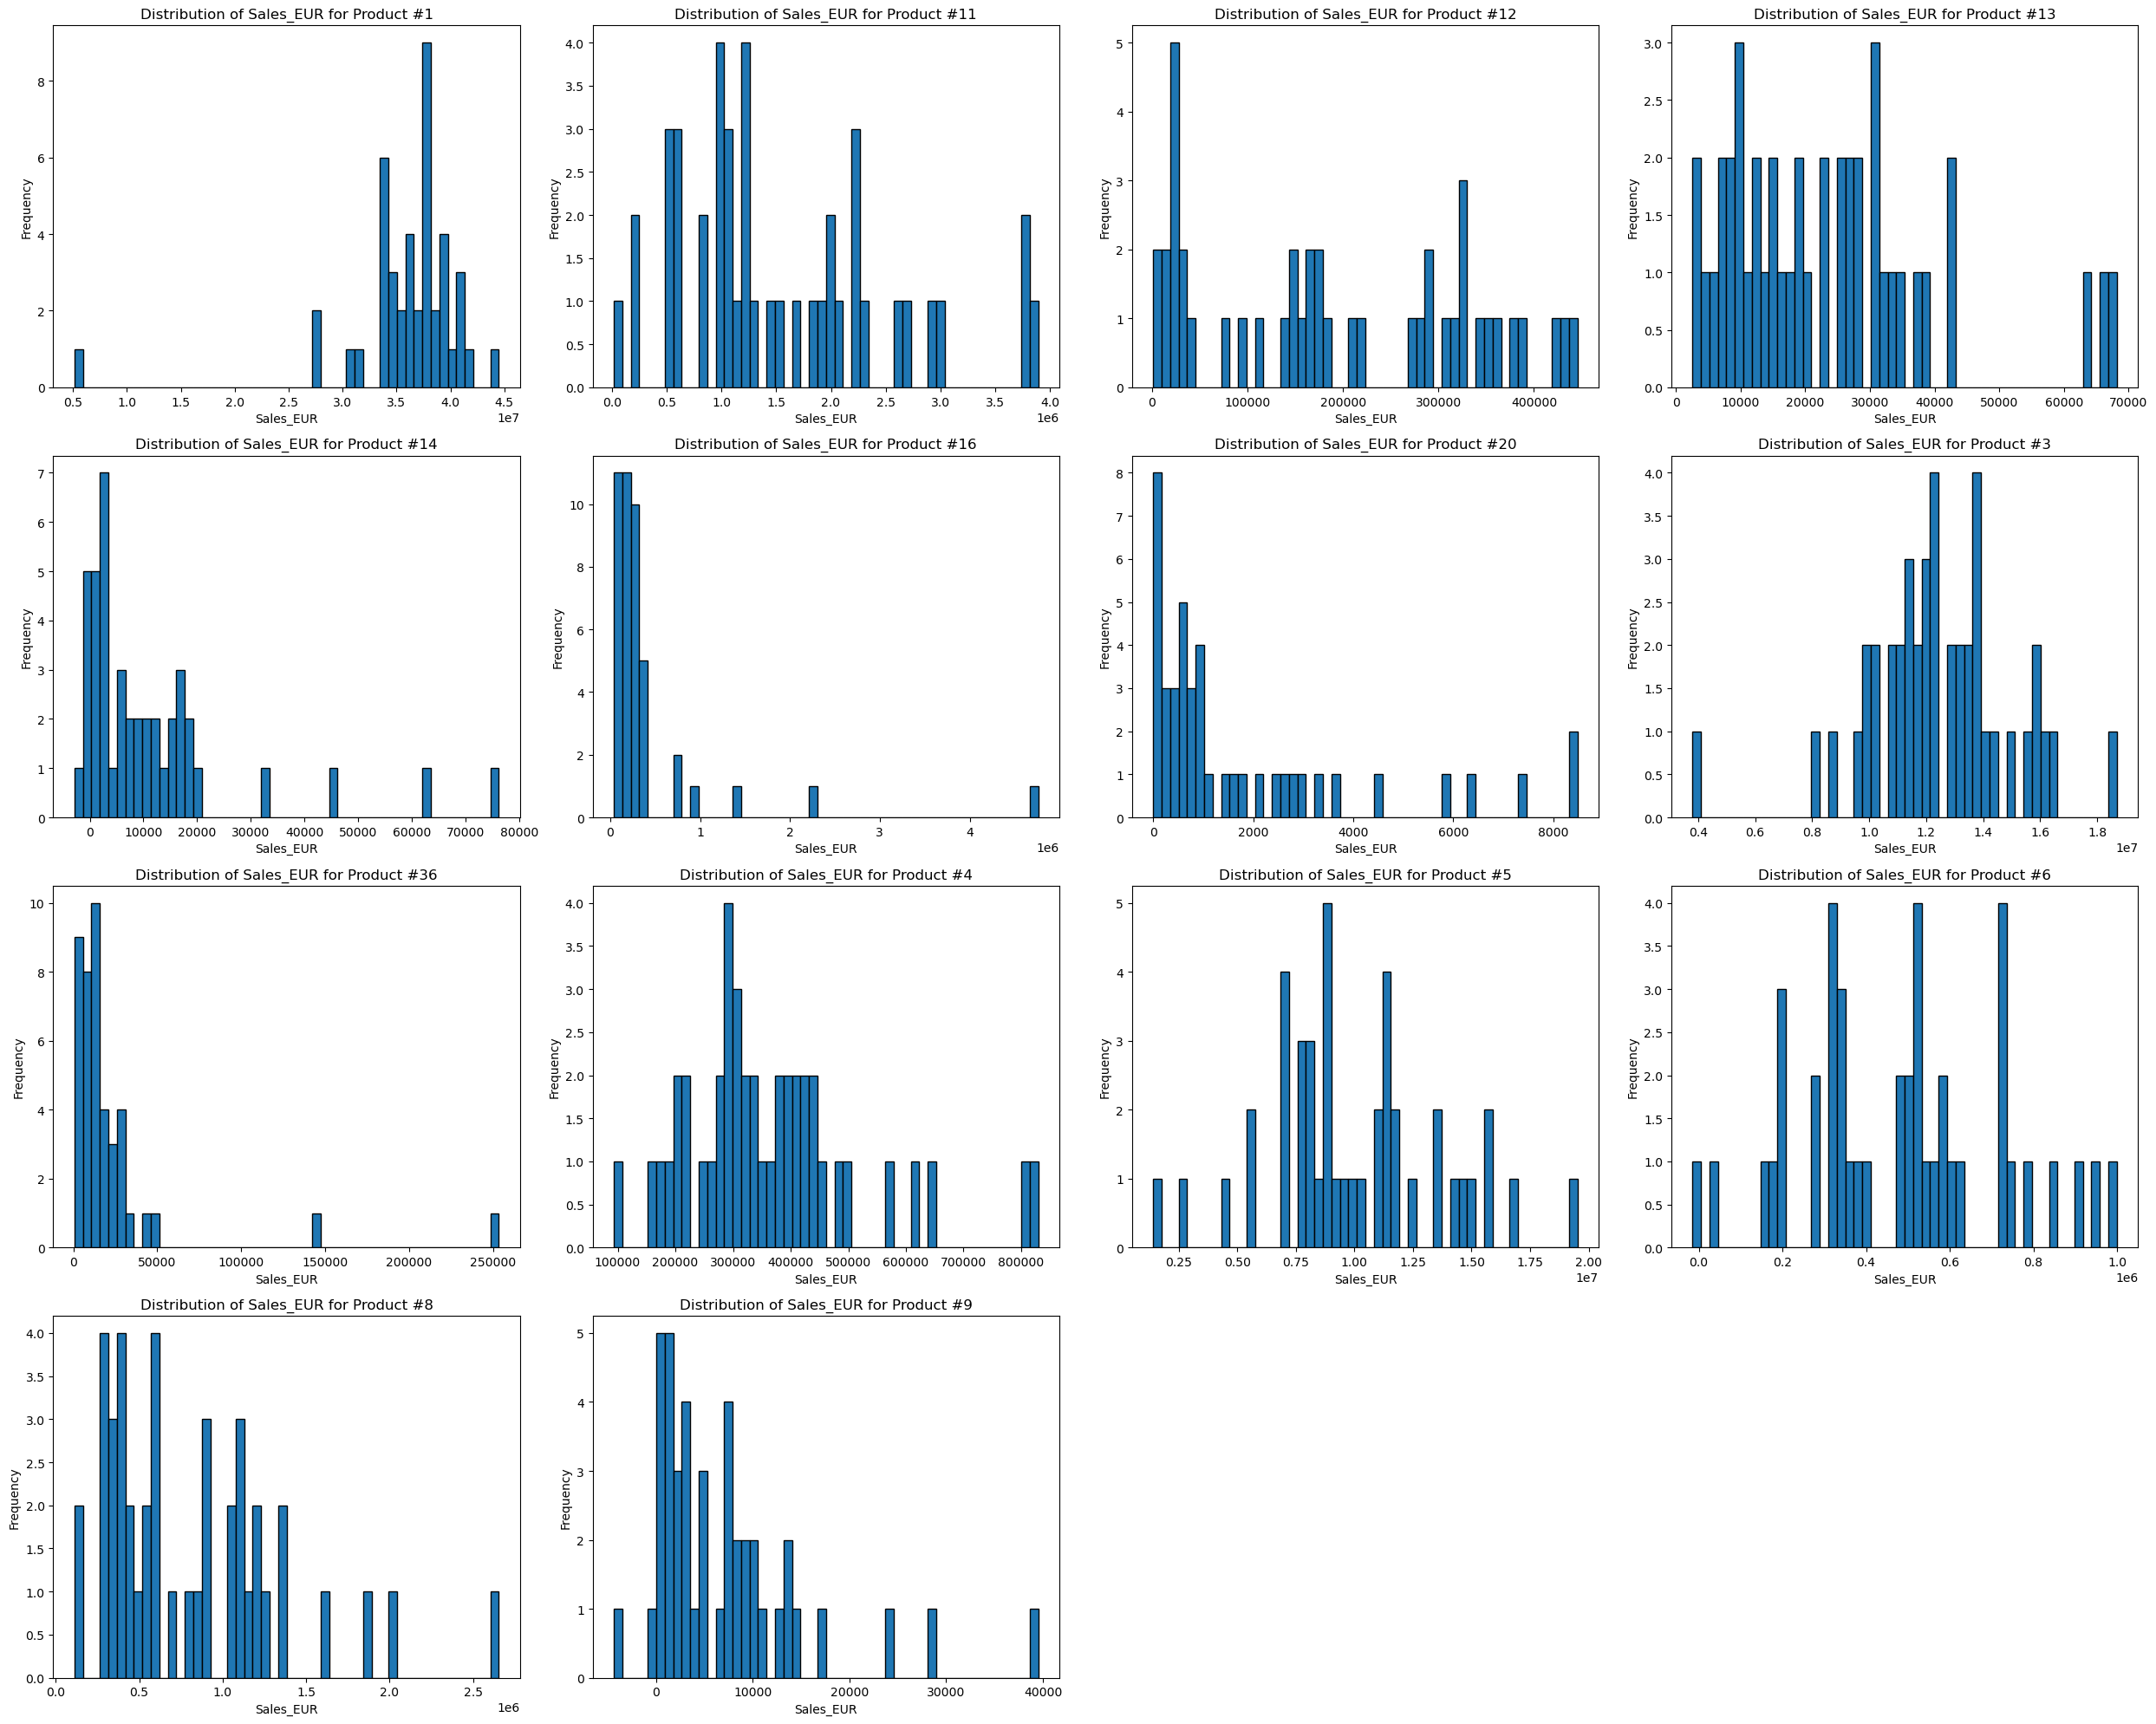

In [356]:
unique_products = monthly_sales_data["Mapped_GCK"].unique()
num_columns = 4
num_rows = (len(unique_products) // num_columns) + int(len(unique_products) % num_columns != 0)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 5 * num_rows))
axes = axes.flatten()

for i, product in enumerate(unique_products):
    axes[i].hist(monthly_sales_data[monthly_sales_data["Mapped_GCK"] == product]["Sales_EUR"], bins=50, edgecolor="black")
    axes[i].set_title(f"Distribution of Sales_EUR for Product {product}")
    axes[i].set_xlabel("Sales_EUR")
    axes[i].set_ylabel("Frequency")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

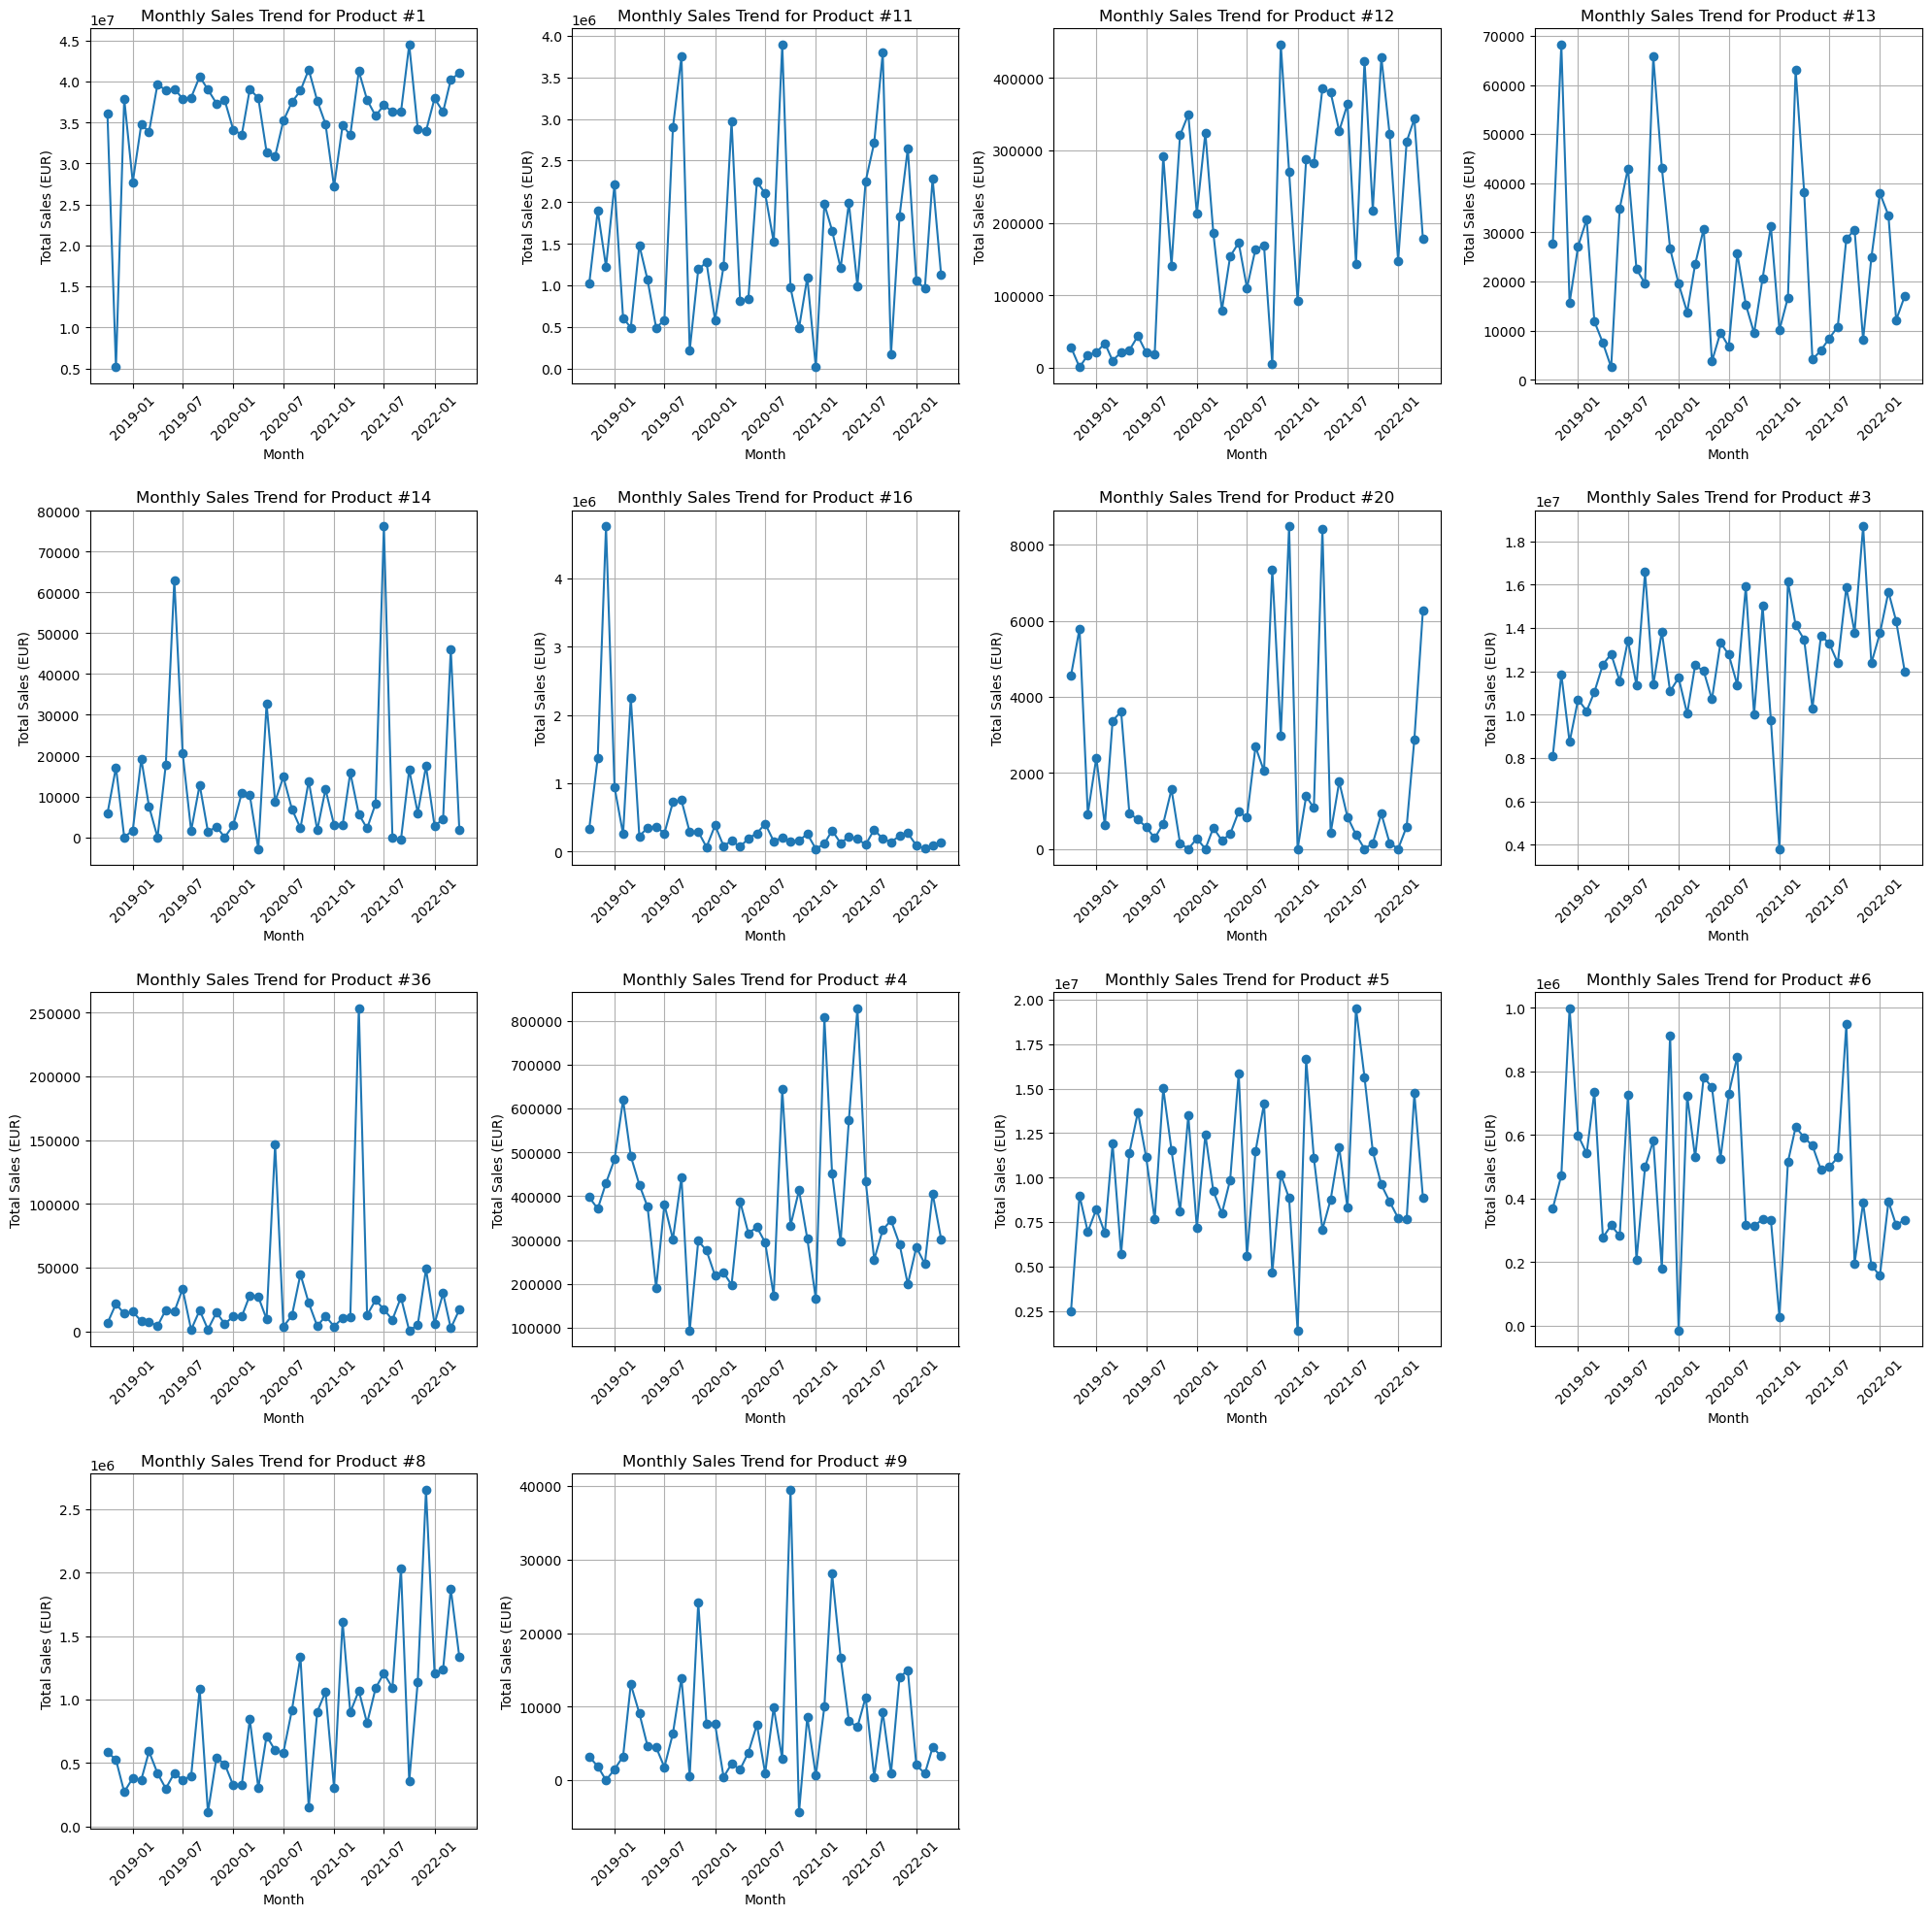

In [357]:
monthly_sales_data["Date"] = pd.to_datetime(monthly_sales_data["Year"].astype(str) + "-" + monthly_sales_data["Month"].astype(str) + "-01")
unique_products = monthly_sales_data["Mapped_GCK"].unique()
num_columns = 4
num_rows = (len(unique_products) // num_columns) + int(len(unique_products) % num_columns != 0)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 5 * num_rows))
axes = axes.flatten()

for i, product in enumerate(unique_products):
    product_data = monthly_sales_data[monthly_sales_data["Mapped_GCK"] == product]
    axes[i].plot(product_data["Date"], product_data["Sales_EUR"], marker="o", linestyle="-")
    axes[i].set_title(f"Monthly Sales Trend for Product {product}")
    axes[i].set_xlabel("Month")
    axes[i].set_ylabel("Total Sales (EUR)")
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

monthly_sales_data = monthly_sales_data.drop(columns=["Date"])

In [358]:
negative_values = monthly_sales_data[monthly_sales_data["Sales_EUR"] < 0]
print(negative_values)

    Mapped_GCK  Year  Month  Sales_EUR
190        #14  2020      4      -2851
207        #14  2021      9       -560
488         #6  2020      1     -15204
584         #9  2020     11      -4358


Check for Duplicate Dates and Their Frequencies

In [359]:
duplicate_dates = sales_data["DATE"].duplicated().sum()
date_counts = sales_data["DATE"].value_counts().sort_index()

print(f"Number of duplicate dates: {duplicate_dates}")
print("\nFirst 10 occurrences of dates:")
print(date_counts.head(10))

Number of duplicate dates: 8586

First 10 occurrences of dates:
DATE
2018-10-01     9
2018-10-02    10
2018-10-03     1
2018-10-04     6
2018-10-05     8
2018-10-06     1
2018-10-08     7
2018-10-09     9
2018-10-10    10
2018-10-11     8
Name: count, dtype: int64


Quantity of Different Products

In [360]:
unique_values = sales_data["Mapped_GCK"].unique()
num_unique_values = len(unique_values)

print(f"Number of unique values in Mapped_GCK: {num_unique_values}")
print("Unique values:")
print(unique_values)

Number of unique values in Mapped_GCK: 14
Unique values:
['#1' '#11' '#6' '#8' '#12' '#16' '#4' '#5' '#3' '#9' '#14' '#13' '#20'
 '#36']


Distribution of Values by Product

In [361]:
mapped_gck_counts = sales_data["Mapped_GCK"].value_counts()
print("Count of each unique value in Mapped_GCK:")
print(mapped_gck_counts)
total_rows = len(sales_data)
print(f"\nTotal number of rows in the dataset: {total_rows}")

Count of each unique value in Mapped_GCK:
Mapped_GCK
#1     1179
#3     1017
#5      959
#8      944
#4      877
#12     803
#6      794
#16     765
#11     732
#13     441
#36     434
#9      333
#20     293
#14     231
Name: count, dtype: int64

Total number of rows in the dataset: 9802


Check for Duplicates 

In [362]:
duplicates_by_gck = sales_data.groupby("Mapped_GCK")["DATE"].apply(lambda x: x.duplicated().sum())

print("Duplicate DATEs per Mapped_GCK:")
print(duplicates_by_gck)

Duplicate DATEs per Mapped_GCK:
Mapped_GCK
#1     0
#11    0
#12    0
#13    0
#14    0
#16    0
#20    0
#3     0
#36    0
#4     0
#5     0
#6     0
#8     0
#9     0
Name: DATE, dtype: int64


Analyze Average Sales by Weekday, Month, and Year

In [363]:
weekday_sales = sales_data.groupby("Weekday")["Sales_EUR"].mean().sort_values()
month_sales = sales_data.groupby("Month")["Sales_EUR"].mean().sort_values()
year_sales = sales_data.groupby("Year")["Sales_EUR"].mean().sort_values()

In [364]:
print(weekday_sales)

Weekday
Saturday     173832.675192
Sunday       191665.814371
Tuesday      200995.492794
Wednesday    212515.561120
Thursday     221827.190011
Monday       347070.474352
Friday       403934.651971
Name: Sales_EUR, dtype: float64


In [365]:
print(month_sales)

Month
1     223989.702222
11    243629.551351
7     254406.813097
10    259941.360515
3     273163.379773
5     273221.225225
6     282490.542569
2     285487.939220
8     288530.137681
4     293675.887078
12    297922.155529
9     311129.041892
Name: Sales_EUR, dtype: float64


In [366]:
print(year_sales)

Year
2018    221508.560250
2020    265281.977690
2019    277406.693069
2021    279945.056481
2022    296520.236872
Name: Sales_EUR, dtype: float64


Visualize Average Sales per Product

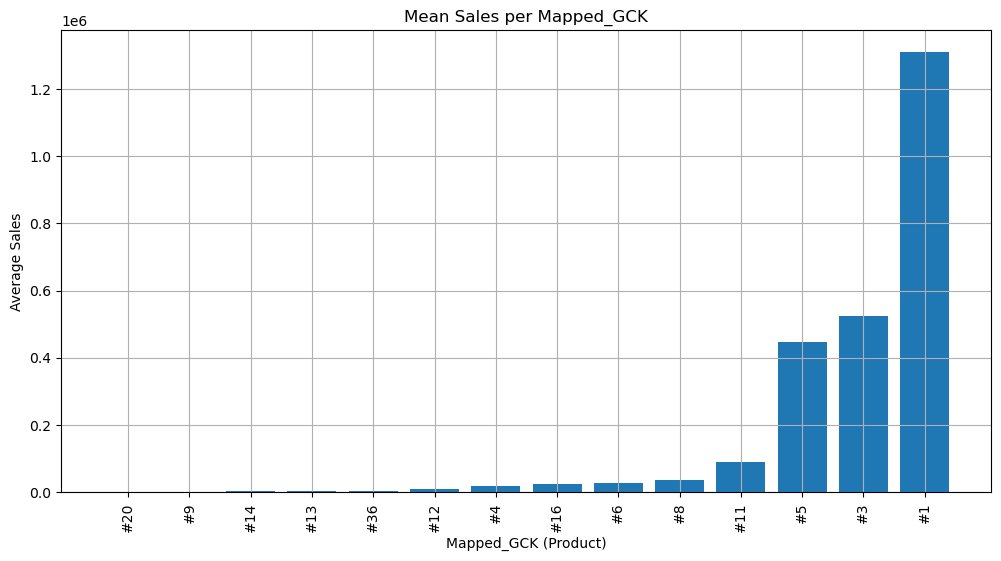

In [367]:
mapped_gck_means = sales_data.groupby("Mapped_GCK")["Sales_EUR"].mean().sort_values()

plt.figure(figsize=(12, 6))
plt.bar(mapped_gck_means.index, mapped_gck_means.values)
plt.xticks(rotation=90)
plt.xlabel("Mapped_GCK (Product)")
plt.ylabel("Average Sales")
plt.title("Mean Sales per Mapped_GCK")
plt.grid(True)
plt.show()

Mean Sales per Product

In [368]:
mapped_gck_means = sales_data.groupby("Mapped_GCK")["Sales_EUR"].mean().sort_values()

print("Mean Sales per Product:")
print(mapped_gck_means)

Mean Sales per Product:
Mapped_GCK
#20    2.672628e+02
#9     9.262072e+02
#14    2.137714e+03
#13    2.288236e+03
#36    2.300864e+03
#12    1.031065e+04
#4     1.781884e+04
#16    2.404064e+04
#6     2.599726e+04
#8     3.693975e+04
#11    9.002908e+04
#5     4.479615e+05
#3     5.245265e+05
#1     1.309759e+06
Name: Sales_EUR, dtype: float64


Check the Sales_Data

In [369]:
sales_data.head(5)

,DATE,Mapped_GCK,Sales_EUR,Weekday,Year,Month
0,2018-10-01,#1,0,Monday,2018,10
1,2018-10-02,#1,0,Tuesday,2018,10
2,2018-10-03,#1,0,Wednesday,2018,10
3,2018-10-04,#1,0,Thursday,2018,10
4,2018-10-05,#1,0,Friday,2018,10


# 4. Market Data Analysis

 Preview first rows of Market Data

In [370]:
market_data.isna().sum()

0      1
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     1
12     1
13     0
14    18
15     0
16     1
17     0
18     0
19     1
20     1
21     1
22     1
23     1
24     1
25     1
26     0
27    18
28     0
29    35
30     0
31    23
32     0
33     0
34     1
35     0
36     0
37     0
38     0
39     0
40     0
41    11
42     1
43     0
44     0
45     0
46     0
47     0
dtype: int64

Clean and Reformat Market Data Header

In [371]:
market_data = market_data.drop(index=2).reset_index(drop=True)

new_columns = [
    f"{market_data.iloc[0, i]} - {market_data.iloc[1, i]}" if pd.notna(market_data.iloc[0, i]) 
    else market_data.iloc[1, i] 
    for i in range(market_data.shape[1])
]

market_data.columns = new_columns
market_data = market_data.iloc[2:].reset_index(drop=True)
market_data = market_data.rename(columns={market_data.columns[0]: "Date"})

Extract Year and Month from Date Column

In [372]:
market_data["Date"] = market_data["Date"].str.strip()
market_data["Year"] = market_data["Date"].str[:4].astype(int)
market_data["Month"] = market_data["Date"].str[5:].astype(int)

Validate Year and Month Extraction

In [373]:
year_counts = market_data["Year"].value_counts().sort_index()
month_counts = market_data["Month"].value_counts().sort_index()

In [374]:
print("Unique Years and Counts:")
print(year_counts)

Unique Years and Counts:
Year
2004    11
2005    12
2006    12
2007    12
2008    12
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015    12
2016    12
2017    12
2018    12
2019    12
2020    12
2021    12
2022     4
Name: count, dtype: int64


In [375]:
print("\nUnique Months and Counts:")
print(month_counts)


Unique Months and Counts:
Month
1     18
2     19
3     19
4     19
5     18
6     18
7     18
8     18
9     18
10    18
11    18
12    18
Name: count, dtype: int64


# 5. Data Preparation

Aggregated the World Price Features

In [376]:
market_data["Key_Materials_Price_Index"] = (
    market_data["World: Price of Base Metals"] +
    market_data["World: Price of Energy"] +
    market_data["World: Price of Crude oil, average"] +
    market_data["World: Price of Copper"] +
    market_data["World: Price of Metals  & Minerals"] +
    market_data["World: Price of Natural gas index"] +
    market_data["Producer Prices - Germany: Electrical equipment"]
) / 7

### Remove Outliers

In [377]:
Q1 = monthly_sales_data["Sales_EUR"].quantile(0.25)
Q3 = monthly_sales_data["Sales_EUR"].quantile(0.75)
IQR = Q3 - Q1

sales_data = monthly_sales_data[
    (monthly_sales_data["Sales_EUR"] >= (Q1 - 1.5 * IQR)) & 
    (monthly_sales_data["Sales_EUR"] <= (Q3 + 1.5 * IQR))
]

print(f"Number of outliers removed (IQR): {len(monthly_sales_data) - len(sales_data)}")

Number of outliers removed (IQR): 127


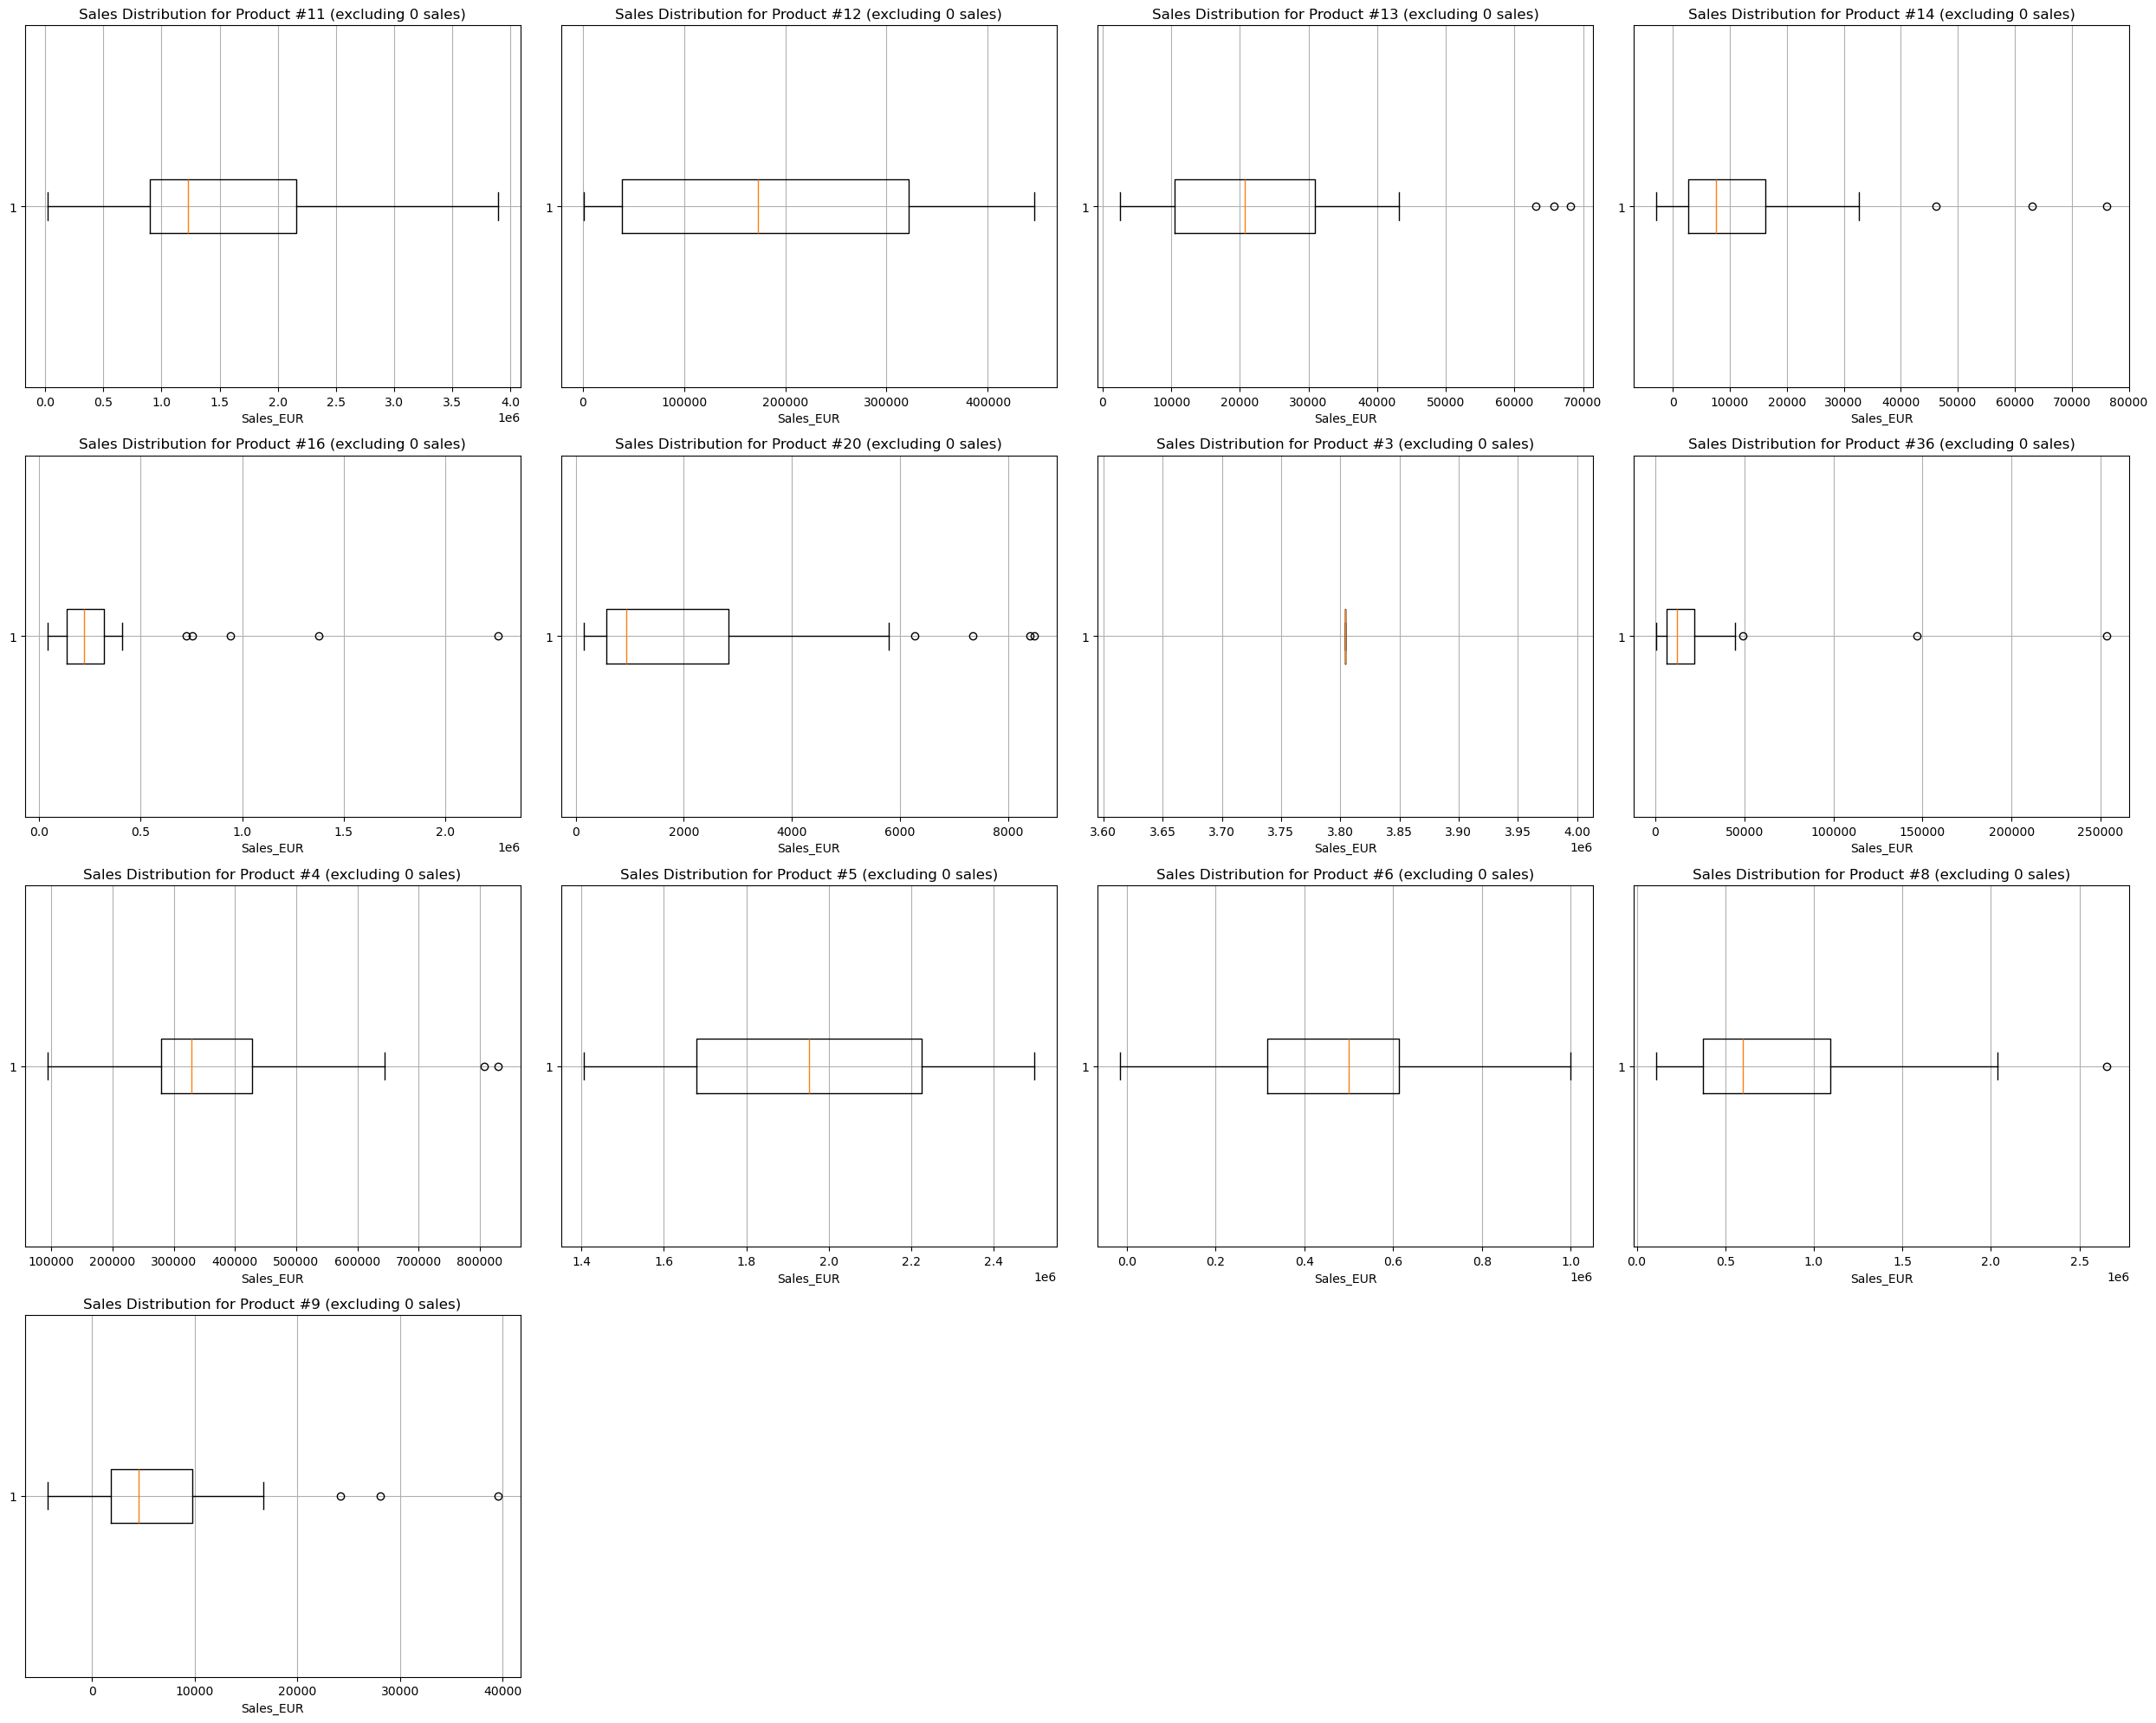

In [378]:
filtered_sales = sales_data[sales_data["Sales_EUR"] != 0]
unique_products = filtered_sales["Mapped_GCK"].unique()
num_columns = 4
num_rows = (len(unique_products) // num_columns) + int(len(unique_products) % num_columns != 0)
fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 5 * num_rows))
axes = axes.flatten()

for i, product in enumerate(unique_products):
    product_data = filtered_sales[filtered_sales["Mapped_GCK"] == product]["Sales_EUR"]
    axes[i].boxplot(product_data, vert=False)
    axes[i].set_title(f"Sales Distribution for Product {product} (excluding 0 sales)")
    axes[i].set_xlabel("Sales_EUR")
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

### 7. Building the Final Dataset & Feature Selection

Merging Data to Create Final Dataset

In [379]:
print(market_data.columns.tolist())

['Date', 'China - Production Index Machinery & Electricals', 'China - Shipments Index Machinery & Electricals', 'France - Production Index Machinery & Electricals', 'France - Shipments Index Machinery & Electricals', 'Germany - Production Index Machinery & Electricals', 'Germany - Shipments Index Machinery & Electricals', 'Italy - Production Index Machinery & Electricals', 'Italy - Shipments Index Machinery & Electricals', 'Japan - Production Index Machinery & Electricals', 'Japan - Shipments Index Machinery & Electricals', 'Switzerland - Production Index Machinery & Electricals', 'Switzerland - Shipments Index Machinery & Electricals', 'United Kingdom - Production Index Machinery & Electricals', 'United Kingdom - Shipments Index Machinery & Electricals', 'United States - Production Index Machinery & Electricals', 'United States - Shipments Index Machinery & Electricals', 'Europe - Production Index Machinery & Electricals', 'Europe - Shipments Index Machinery & Electricals', 'World: Pr

In [380]:
market_selected = market_data[
    ["Year", "Month", "Key_Materials_Price_Index",
     "China - Production Index Machinery & Electricals",
     "United States - Production Index Machinery & Electricals",
     "Germany - Production Index Machinery & Electricals",
     "Europe - Production Index Machinery & Electricals",
     "China - Shipments Index Machinery & Electricals",
     "United States - Shipments Index Machinery & Electricals",
     "Germany - Shipments Index Machinery & Electricals",
     "Producer Prices - Germany: Electrical equipment",
     "Producer Prices - United States: Electrical equipment",
     "Producer Prices - China: Electrical equipment",
     "United States: EUR in LCU"]
]
merged_data = sales_data.merge(market_selected, on=["Year", "Month"], how="left")

print(merged_data.head()) 

  Mapped_GCK  Year  Month  Sales_EUR Key_Materials_Price_Index  \
0        #11  2018     10    1021303                 91.998214   
1        #11  2018     11    1898844                 87.634067   
2        #11  2018     12    1226122                 83.762772   
3        #11  2019      1    2216391                 81.920907   
4        #11  2019      2     610456                 83.607004   

  China - Production Index Machinery & Electricals  \
0                                       211.955755   
1                                       220.519655   
2                                       241.846854   
3                                       175.668147   
4                                       175.668147   

  United States - Production Index Machinery & Electricals  \
0                                          111.90254         
1                                         110.880401         
2                                         106.257796         
3                             

Renaming Columns for Clarity

In [381]:
merged_data.rename(columns={
    "China - Production Index Machinery & Electricals": "Global_Industrial_Activity_Index",
    "World: Price of Metals & Minerals": "Metals_Minerals_Price",
    "World: Price of Natural Gas": "Natural_Gas_Price",
    "World: Producer Prices": "Producer_Price_Index"
}, inplace=True)

Converting Product Variable to Integer Type

In [382]:
merged_data["Mapped_GCK"] = merged_data["Mapped_GCK"].str.replace("#", "").str.strip()
merged_data["Mapped_GCK"] = merged_data["Mapped_GCK"].astype(int)

In [383]:
merged_data["Quarter"] = merged_data["Month"].apply(lambda x: (x - 1) // 3 + 1)
merged_data["Is_Holiday_Month"] = merged_data["Month"].apply(lambda x: 1 if x == 12 else 0)
merged_data["Sales_Lag_1M"] = merged_data.groupby("Mapped_GCK")["Sales_EUR"].shift(1)
merged_data["Sales_Lag_12M"] = merged_data.groupby("Mapped_GCK")["Sales_EUR"].shift(12)

In [384]:
merged_data.fillna({"Sales_Lag_1M": merged_data["Sales_EUR"].mean(),
                    "Sales_Lag_12M": merged_data["Sales_EUR"].mean()}, inplace=True)

In [385]:
print(merged_data.columns.tolist())

['Mapped_GCK', 'Year', 'Month', 'Sales_EUR', 'Key_Materials_Price_Index', 'Global_Industrial_Activity_Index', 'United States - Production Index Machinery & Electricals', 'Germany - Production Index Machinery & Electricals', 'Europe - Production Index Machinery & Electricals', 'China - Shipments Index Machinery & Electricals', 'United States - Shipments Index Machinery & Electricals', 'Germany - Shipments Index Machinery & Electricals', 'Producer Prices - Germany: Electrical equipment', 'Producer Prices - United States: Electrical equipment', 'Producer Prices - China: Electrical equipment', 'United States: EUR in LCU', 'Quarter', 'Is_Holiday_Month', 'Sales_Lag_1M', 'Sales_Lag_12M']


Correlation Matrix

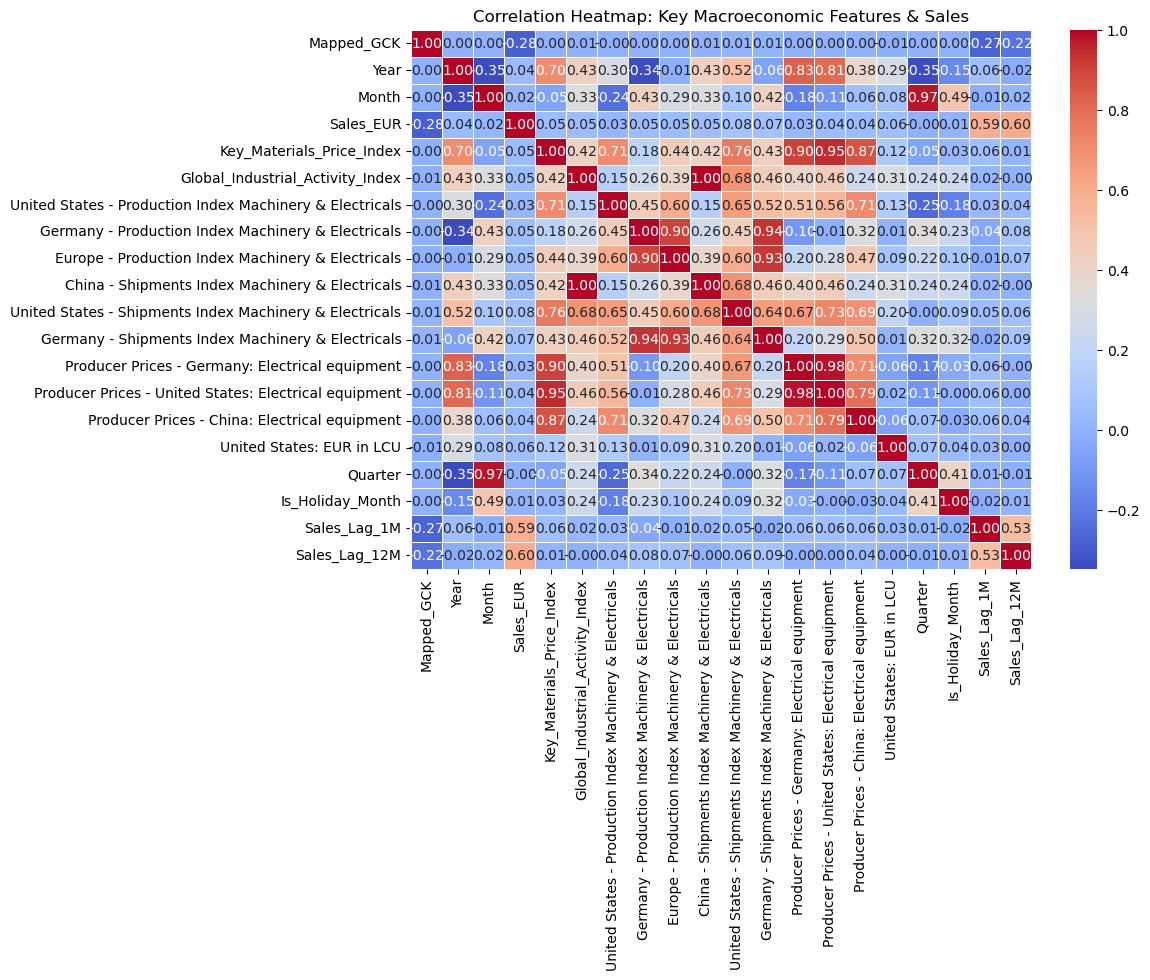

In [386]:
correlation_matrix = merged_data.corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Key Macroeconomic Features & Sales")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### **Correlation Matrix Analysis & Feature Selection**

In this section, we analyzed the correlation between key macroeconomic features and sales (Sales_EUR) to guide feature selection for modeling. The correlation matrix was used to identify highly correlated features and determine which variables could be dropped to avoid multicollinearity.

#### **Key Insights from the Correlation Matrix:**

1. **High Correlation Between Production and Shipments Indices:**
   - **Germany**, **United States**, and **China** show very high correlations between the **Production Index** and **Shipments Index** (values above 0.9). These indices represent similar economic activities (production and shipments), making one of the indices redundant.
   
   **Action**: Dropped **Shipments Index** for all three countries (Germany, USA, China) and kept **Production Index**.

2. **High Correlation Between Producer Prices:**
   - **Producer Prices - United States: Electrical equipment** and **Producer Prices - Germany: Electrical equipment** are strongly correlated (0.98).
   
   **Action**: Dropped **Producer Prices - Germany: Electrical equipment** as it's highly correlated with **Producer Prices - United States: Electrical equipment**.

3. **Sales Lag Variables:**
   - **Sales_Lag_1M** and **Sales_Lag_12M** are highly correlated with **Sales_EUR**.
   
   **Action**: Dropped **Sales_Lag_1M** as **Sales_Lag_12M** captures long-term trends and shows high correlation with the target.

4. **Seasonality (Quarter) and Holiday Month:**
   - The **Quarter** feature shows some correlation with other time-based features.
   
   **Action**: Dropped **Quarter** since **Sales_Lag_12M** and **Is_Holiday_Month** could capture the seasonality and holiday effects.

#### **Final Feature Removal Decision:**
Based on the analysis of correlations, we dropped the following features:
- **Shipments Indices** for Germany, USA, and China
- **Producer Prices - Germany: Electrical equipment**
- **Sales_Lag_1M**
- **Quarter**

In [387]:
merged_data.columns.tolist()

['Mapped_GCK',
 'Year',
 'Month',
 'Sales_EUR',
 'Key_Materials_Price_Index',
 'Global_Industrial_Activity_Index',
 'United States - Production Index Machinery & Electricals',
 'Germany - Production Index Machinery & Electricals',
 'Europe - Production Index Machinery & Electricals',
 'China - Shipments Index Machinery & Electricals',
 'United States - Shipments Index Machinery & Electricals',
 'Germany - Shipments Index Machinery & Electricals',
 'Producer Prices - Germany: Electrical equipment',
 'Producer Prices - United States: Electrical equipment',
 'Producer Prices - China: Electrical equipment',
 'United States: EUR in LCU',
 'Quarter',
 'Is_Holiday_Month',
 'Sales_Lag_1M',
 'Sales_Lag_12M']

Removing Unused Transformation Columns

In [388]:
merged_data = merged_data.drop(columns=[
    "Key_Materials_Price_Index",
    "Producer Prices - Germany: Electrical equipment",
    "United States: EUR in LCU",
    "Germany - Shipments Index Machinery & Electricals",
    "United States - Shipments Index Machinery & Electricals",
    "China - Shipments Index Machinery & Electricals",
    "Sales_Lag_1M",
    "Quarter"
])

In [389]:
merged_data

,Mapped_GCK,Year,Month,Sales_EUR,Global_Industrial_Activity_Index,United States - Production Index Machinery & Electricals,Germany - Production Index Machinery & Electricals,Europe - Production Index Machinery & Electricals,Producer Prices - United States: Electrical equipment,Producer Prices - China: Electrical equipment,Is_Holiday_Month,Sales_Lag_12M
0,11,2018,10,1021303,211.955755,111.90254,124.227879,124.391967,110.700409,96.318329,0,356939.543158
1,11,2018,11,1898844,220.519655,110.880401,127.404132,123.070091,110.994026,95.370118,0,356939.543158
2,11,2018,12,1226122,241.846854,106.257796,120.518565,113.858005,111.162231,94.994885,1,356939.543158
3,11,2019,1,2216391,175.668147,107.510808,104.776326,106.418002,111.386055,94.950134,0,356939.543158
4,11,2019,2,610456,175.668147,109.817608,109.597012,110.42959,111.561142,94.712204,0,356939.543158
...,...,...,...,...,...,...,...,...,...,...,...,...
470,9,2021,12,14935,310.763183,107.040766,118.103281,123.076659,128.511261,98.1062,1,8606.000000
471,9,2022,1,2065,235.956129,111.052133,94.55061,103.199827,131.62851,98.280171,0,625.000000
472,9,2022,2,902,235.956129,116.336327,103.987916,113.500635,133.342178,98.714158,0,10022.000000
473,9,2022,3,4452,329.413367,117.654038,121.308119,133.13301,136.153778,99.021554,0,28108.000000


Copy with "YearMonth" 

In [390]:
merged_data_2 = merged_data.copy()
merged_data_2["YearMonth"] = (
    merged_data_2["Year"].astype(str) + "-" + 
    merged_data_2["Month"].astype(str).str.zfill(2)
)

merged_data_2 = merged_data_2.drop(columns=["Year", "Month"])
merged_data_2

,Mapped_GCK,Sales_EUR,Global_Industrial_Activity_Index,United States - Production Index Machinery & Electricals,Germany - Production Index Machinery & Electricals,Europe - Production Index Machinery & Electricals,Producer Prices - United States: Electrical equipment,Producer Prices - China: Electrical equipment,Is_Holiday_Month,Sales_Lag_12M,YearMonth
0,11,1021303,211.955755,111.90254,124.227879,124.391967,110.700409,96.318329,0,356939.543158,2018-10
1,11,1898844,220.519655,110.880401,127.404132,123.070091,110.994026,95.370118,0,356939.543158,2018-11
2,11,1226122,241.846854,106.257796,120.518565,113.858005,111.162231,94.994885,1,356939.543158,2018-12
3,11,2216391,175.668147,107.510808,104.776326,106.418002,111.386055,94.950134,0,356939.543158,2019-01
4,11,610456,175.668147,109.817608,109.597012,110.42959,111.561142,94.712204,0,356939.543158,2019-02
...,...,...,...,...,...,...,...,...,...,...,...
470,9,14935,310.763183,107.040766,118.103281,123.076659,128.511261,98.1062,1,8606.000000,2021-12
471,9,2065,235.956129,111.052133,94.55061,103.199827,131.62851,98.280171,0,625.000000,2022-01
472,9,902,235.956129,116.336327,103.987916,113.500635,133.342178,98.714158,0,10022.000000,2022-02
473,9,4452,329.413367,117.654038,121.308119,133.13301,136.153778,99.021554,0,28108.000000,2022-03


# 8. Modelling

Time-Based Train-Test Split

In [ ]:
merged_data_2 = merged_data_2.sort_values(by=["YearMonth"])
split_point = int(len(merged_data_2) * 0.8)
train_data, test_data = merged_data_2.iloc[:split_point], merged_data_2.iloc[split_point:]
target = "Sales_EUR_Log"
excluded_features = ["YearMonth", "Sales_EUR", "Sales_EUR_Log"]
features = [col for col in merged_data_2.columns if col not in excluded_features]

X_train, X_test = train_data[features], test_data[features]
y_train, y_test = train_data[target], test_data[target]

print(f"Train set size: {len(train_data)} rows")
print(f"Test set size: {len(test_data)} rows")
print("Missing values in train set:", X_train.isnull().sum().sum())
print("Missing values in test set:", X_test.isnull().sum().sum())

In [ ]:
X_test.loc[:, "United States - Shipments Index Machinery & Electricals"] = X_test["United States - Shipments Index Machinery & Electricals"].fillna(X_train["United States - Shipments Index Machinery & Electricals"].mean())

Calculating Acceptable RMSE Threshold per Product

In [ ]:
ACCEPTABLE_PERCENTAGE = 20  
rmse_thresholds = []

for product_id in train_data["Mapped_GCK"].unique():
    median_sales = train_data[train_data["Mapped_GCK"] == product_id]["Sales_EUR"].median()
    threshold = (ACCEPTABLE_PERCENTAGE / 100) * median_sales
    rmse_thresholds.append([product_id, int(threshold)])

rmse_threshold_df = pd.DataFrame(rmse_thresholds, columns=["Mapped_GCK", "RMSE_Threshold"])
rmse_threshold_df

# Prophet

In [ ]:
forecast_results = []

for product_id in merged_data_2["Mapped_GCK"].unique():
    product_data = merged_data_2[merged_data_2["Mapped_GCK"] == product_id].copy()
    prophet_df = product_data[['YearMonth', 'Sales_EUR_Log']].rename(columns={'YearMonth': 'ds', 'Sales_EUR_Log': 'y'})
    prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])
    model = Prophet()
    model.fit(prophet_df)
    future = model.make_future_dataframe(periods=10, freq='MS')
    forecast = model.predict(future)
    future_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)
    future_forecast['Mapped_GCK'] = product_id
    forecast_results.append(future_forecast)

forecast_results_df = pd.concat(forecast_results, ignore_index=True)

plt.figure(figsize=(12,6))
for product_id in merged_data_2["Mapped_GCK"].unique():
    product_data = merged_data_2[merged_data_2["Mapped_GCK"] == product_id]
    plt.plot(product_data['YearMonth'], product_data['Sales_EUR_Log'], label=f"Product {product_id} Historical Sales", alpha=0.7)

plt.plot(forecast_results_df['ds'], forecast_results_df['yhat'], label="Forecast", linestyle='dashed', color='red')
plt.axvline(x='2022-05-01', color='black', linestyle='--', label="Forecast Start")
plt.fill_between(forecast_results_df['ds'], forecast_results_df['yhat_lower'], forecast_results_df['yhat_upper'], color='red', alpha=0.2)
plt.legend()
plt.title("Prophet Forecast for Sales")
plt.xlabel("Date")
plt.ylabel("Log Sales")
plt.show()

# XGB

In [ ]:
print(test_data.columns)
test_data["YearMonth"] = pd.to_datetime(test_data["Year"].astype(str) + "-" + test_data["Month"].astype(str) + "-01")

In [ ]:
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=9,
    subsample=1.0,
    colsample_bytree=0.6,
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred_xgb_log = xgb_model.predict(X_test)
y_pred_xgb = np.expm1(y_pred_xgb_log)
y_test_actual = np.expm1(y_test)

rmse_xgb = mean_squared_error(y_test_actual, y_pred_xgb, squared=False)
print("XGBoost RMSE:", rmse_xgb)

future_X = X_test.iloc[-10:].copy()
future_X = future_X.drop(columns=['YearMonth'], errors='ignore')
future_predictions_log = xgb_model.predict(future_X)
future_predictions = np.expm1(future_predictions_log)
last_date = pd.to_datetime(test_data["Year"].astype(str) + "-" + test_data["Month"].astype(str) + "-01").max()
future_dates = pd.date_range(start=last_date, periods=11, freq="MS")[1:]

plt.figure(figsize=(12, 6))
sns.lineplot(x=test_data["Year"].astype(str) + "-" + test_data["Month"].astype(str), 
             y=np.expm1(test_data["Sales_EUR_Log"]), label="Actual Sales", marker="o", color="orange")
sns.lineplot(x=future_dates.strftime('%Y-%m'), y=future_predictions, label="XGBoost Forecast", linestyle="dashed", color="blue")

plt.xticks(rotation=45)
plt.xlabel("Year-Month")
plt.ylabel("Sales (EUR)")
plt.title("XGBoost Sales Forecast for the Next 10 Months")
plt.legend()
plt.grid(True)
plt.show()

# RF

In [ ]:
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5, 
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42
)

rf_model.fit(X_train, y_train)
y_pred_rf_log = rf_model.predict(X_test)
y_pred_rf = np.expm1(y_pred_rf_log)
y_test_actual = np.expm1(y_test)

rmse_rf = mean_squared_error(y_test_actual, y_pred_rf, squared=False)
print("Random Forest RMSE:", rmse_rf)

future_X = X_test.iloc[-10:].copy() 
future_X = future_X.drop(columns=['YearMonth'], errors='ignore')
future_predictions_rf_log = rf_model.predict(future_X)
future_predictions_rf = np.expm1(future_predictions_rf_log)
last_date = pd.to_datetime(test_data["Year"].astype(str) + "-" + test_data["Month"].astype(str) + "-01").max()
future_dates = pd.date_range(start=last_date, periods=11, freq="MS")[1:]

plt.figure(figsize=(12, 6))
sns.lineplot(x=test_data["Year"].astype(str) + "-" + test_data["Month"].astype(str), 
             y=np.expm1(test_data["Sales_EUR_Log"]), label="Actual Sales", marker="o", color="orange")
sns.lineplot(x=future_dates.strftime('%Y-%m'), y=future_predictions_rf, label="RF Forecast", linestyle="dotted", color="green")

plt.xticks(rotation=45)
plt.xlabel("Year-Month")
plt.ylabel("Sales (EUR)")
plt.title("Random Forest Sales Forecast for the Next 10 Months")
plt.legend()
plt.grid(True)
plt.show()

# SARIMA